# 추천 시스템 - 영화 데이터셋과 Embedding & Ranking 알고리즘으로 추천시스템 만들기

## Step 1. Word2Vec 알고리즘 기반 추천 후보군 생성

#### Rating Matrix 기반 추천시스템의 한계

    [Memory Based Recommendations]
    1. 만약 유저, 영화의 수가 3000이 아니라 3천만 개 라면?
    2. Matrix의 크기는 30,000,000 X 30,000,000
    3. 연산량 자체도 문제가 되지만, Extreme Sparse 벡터가 되면서 정확도 역시 현저하게 떨어지게 됨
    4. 차원축소, ALS 등의 방법으로 어느정도 극복할 수 있지만, 근본적인 해결책이 되지는 못함

    - Recommendation in Large Scale System
  - Architecture
  ![recsys_architecture](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2F30pCp%2Fbtqv7PV6365%2FCkl5dwvSoQF3RdneCIzGr1%2Fimg.png)
  - 데이터 수집과 처리 단계를 제외하면, 추천시스템은 다음과 같은 레이어로 구분되는 추세
    - `Generate Candidates` : 수백, 수천만개의 Item 중, 후보가 될 만한 Item을 추출. 여기에 CF 등의 방법을 사용할 수도 있지만, 일반적으로는 연산량이 작은 여러 개의 전략(시나리오)들을 합쳐서 coverage 자체를 확보하는 역할을 함. 예를 들면 인기도가 높은 Item, 연관성이 높은 Item 등을 별개의 전략으로 추출하는 것.
    - `Intention Predict` : User의 Context에 기반하여 Candidates를 한 번 더 좁혀주는 역할. 반드시 필요한 단계는 아니며, Candidates를 추렸음에도 여전히 Large Scale 문제를 가지고 있는 경우에 필터링의 역할로 사용할 수 있음.
    - `Personalized Ranking` : 일반적으로 추천시스템에서 추천이 잘 되었는지를 평가하는 지표는 CTR, CVR 같은 지표. 이 지표들을 Maximize 할 수 있는 방법으로 개인화 모델을 학습. 일반적인 Classifier를 생각해도 무방하며, 학습 데이터셋을 잘 구축하는 것이 좋은 추천 랭킹모델을 만드는 것.

![recsys_architecture2](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FUsbKo%2Fbtqv7PBN46z%2Fd4m5pf7lrKs1CqxzkROY81%2Fimg.png)


-----

#### Word2Vec 기반의 Movie2Vec 만들기

    [Word2Vec]
    1. 임베딩(Embedding) 방법론 중 가장 대중적이고 성능이 좋은 방법
    2. 같은 문장 내, 혹은 비슷한 위치에 등장하는 단어들은 유사한 의미를 가지고 있을 것이라는 가정.
    3. 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음
    4. Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.
      - 예시 문장 : "역시 성공은 고난을 동반 말없이 등산을 등반하는 것처럼"
      - 만약 "성공"이라는 단어를 중심 단어로 활용한다면, [역시, _, 고난을, 동반] 이러한 주변 단어를 가지고 중심에 있는 단어의 벡터를 학습할 수 있게 됨. (Skip-gram 방식. CBOW는 반대)

### 데이터 불러오기

In [2]:
import pandas as pd

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df = pd.io.parsers.read_csv(rating_url, names=['user_id', 'movie_id', 'rating', 'time'], delimiter='::', engine ='python')

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df = pd.io.parsers.read_csv(movie_url, names=['movie_id', 'title', 'genre'], delimiter='::', engine ='python', encoding='ISO-8859-1')

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df = pd.io.parsers.read_csv(user_url, names=['user_id', 'gender', 'age', 'occupation', 'zipcode'], delimiter='::', engine ='python')

In [3]:
# EDA & 전처리 - 사용자별 시청 목록 추출
def get_movie_list_sort_by_time(x):
  return x.sort_values(['time'])['movie_id'].tolist()

user_watch_list = rating_df.groupby('user_id')[['movie_id', 'time']].apply(lambda x: get_movie_list_sort_by_time(x))

In [4]:
user_watch_list[:3]

user_id
1    [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2    [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3    [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
dtype: object

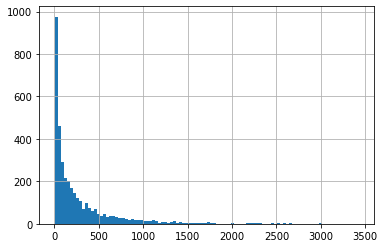

In [5]:
rating_df['movie_id'].value_counts().hist(bins=100)

In [6]:
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# 영화 개봉년도 피쳐 생성
movie_df['released_year_area'] = movie_df['title'].apply(lambda x: x[-5:-2]+"0")
movie_df.head()

,movie_id,title,genre,released_year_area
0,1,Toy Story (1995),Animation|Children's|Comedy,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990
2,3,Grumpier Old Men (1995),Comedy|Romance,1990
3,4,Waiting to Exhale (1995),Comedy|Drama,1990
4,5,Father of the Bride Part II (1995),Comedy,1990


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


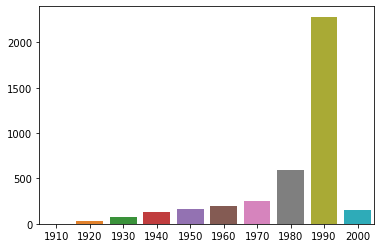

In [8]:
import seaborn as sns

released_year_area = movie_df['released_year_area'].value_counts().sort_index()
sns.barplot(released_year_area.index, released_year_area.values);

In [9]:
# 영화 장르 피쳐 생성
movie_df['genre'].value_counts()

Drama                                 843
Comedy                                521
Horror                                178
Comedy|Drama                          162
Comedy|Romance                        142
                                     ... 
Adventure|Children's|Drama|Romance      1
Drama|Mystery|Sci-Fi|Thriller           1
Action|Drama|Sci-Fi|Thriller            1
Comedy|Drama|Musical                    1
Horror|Mystery                          1
Name: genre, Length: 301, dtype: int64

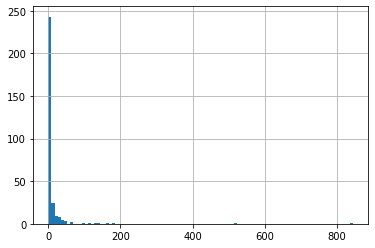

In [10]:
movie_df['genre'].value_counts().hist(bins=100)

In [11]:
movie_df['main_genre'] = movie_df['genre'].apply(lambda x: x.split("|")[0])

In [12]:
movie_df['main_genre'].value_counts()

Drama          1176
Comedy         1024
Action          503
Horror          262
Adventure       155
Crime           131
Documentary     123
Thriller        101
Animation        90
Children's       89
Romance          50
Sci-Fi           46
Mystery          36
Western          33
Musical          25
Film-Noir        25
War              12
Fantasy           2
Name: main_genre, dtype: int64

In [13]:
# Embedding - EDA 결과를 활용하여 Movie2Vec 학습
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [14]:
movie_meta_dict = movie_df.set_index('movie_id')[['released_year_area', 'main_genre']].to_dict()

In [15]:
movie2vec_dataset = []
for movie_list in user_watch_list:
  meta_list = []
  for movie_id in movie_list:
    word_meta_1 = "movie_id:" + str(movie_id)
    word_meta_2 = "year:" + movie_meta_dict['released_year_area'][movie_id]
    word_meta_3 = "genre:" + movie_meta_dict['main_genre'][movie_id]
    meta_list.append(word_meta_1)
    meta_list.append(word_meta_2)
    meta_list.append(word_meta_3)
  movie2vec_dataset.append(meta_list)

In [16]:
!pip install gensim

In [17]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 size=100,
                 window=6,  # 주변 word의 윈도우
                 sg=1,  # skip-gram OR cbow
                 hs=0,  # hierarchical softmax OR negative sampling
                 negative=20,  # negative sampling 파라미터
                 min_count=1,  # word의 등장 최소 횟수
                 iter=20)

In [19]:
# Embedding - 일부 데이터로 Movie2Vec 학습 결과 확인
model.wv.vectors.shape

(3734, 100)

In [20]:
model.wv.most_similar("movie_id:1", topn=5)

[('movie_id:1223', 0.8223292827606201),
 ('movie_id:3429', 0.74729323387146),
 ('movie_id:2324', 0.7024251818656921),
 ('movie_id:2289', 0.6818866729736328),
 ('movie_id:3114', 0.6811957359313965)]

In [21]:
movie_df[movie_df['movie_id'].isin([1223, 3429, 2324, 1537, 3114])]

,movie_id,title,genre,released_year_area,main_genre
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1990,Animation
1499,1537,Shall We Dance? (Shall We Dansu?) (1996),Comedy,1990,Comedy
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1990,Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1990,Animation
3360,3429,Creature Comforts (1990),Animation|Comedy,1990,Animation


In [22]:
# Movie2Vec 모델로 Item2Item 후보군 생성
item2item = {}

# 영화별 연관 영화 k개씩 추출
k = 10
not_in_count = 0
for movie_id in movie_df['movie_id'].values:
  item2item[movie_id] = []
  try:
    sim_list = model.wv.most_similar("movie_id:" + str(movie_id), topn=k+10)
    for movie_tup in sim_list:
      tup_info = movie_tup[0].split(":")
      if (tup_info[0] == "movie_id") and (len(item2item[movie_id]) < 10):
        item2item[movie_id].append(tup_info[1])
  except:
    not_in_count += 1
    print("word", str(movie_id) ,"not in vocabulary")

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

In [23]:
print("total:", not_in_count)

total: 177


In [25]:
str(item2item)[:100]

"{1: ['1223', '3429', '2324', '2289', '3114', '1537', '1148', '745', '1265', '235'], 2: ['60', '3489'"